<a href="https://colab.research.google.com/github/surendran2566/Personalized-Healthcare-Recommendations/blob/main/Personalized_Healthcare_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
            # Personalized Healthcare Recommendations – Machine Learning Project

"""
This project develops a machine learning model that gives tailored healthcare advice using real patient data from various sources.
It includes all essential phases: understanding the problem, preparing and exploring data, preprocessing, engineering features,
training multiple models, and producing personalized recommendations.

Datasets used:
- blood.csv
- examination.csv
- labs.csv
- medications.csv
- questionnaire.csv
- demographic.csv
- diet.csv
"""

# Step 1: Problem Understanding
# Goal: Predict and recommend healthcare actions based on personal health indicators (blood markers, vitals, habits).

In [ ]:
# Step 2: Import Required Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Step 3: Upload and Load Datasets in Colab

from google.colab import files
uploaded = files.upload()

# Read each uploaded file with encoding fallback
def safe_read_csv(filename):
    try:
        return pd.read_csv(filename)
    except UnicodeDecodeError:
        return pd.read_csv(filename, encoding='latin1')

blood = safe_read_csv("blood.csv")
examination = safe_read_csv("examination.csv")
labs = safe_read_csv("labs.csv")
medications = safe_read_csv("medications.csv")
questionnaire = safe_read_csv("questionnaire.csv")
demographic = safe_read_csv("demographic.csv")
diet = safe_read_csv("diet.csv")

# Combine datasets on common key 'SEQN' if present
datasets = {
    "examination": examination,
    "labs": labs,
    "medications": medications,
    "questionnaire": questionnaire,
    "diet": diet,
    "blood": blood
}

data = demographic.copy()

for name, df in datasets.items():
    if 'SEQN' in df.columns:
        data = pd.merge(data, df, on='SEQN', how='left')
    else:
        print(f"⚠️ Skipping {name}: 'SEQN' column not found. Columns = {df.columns.tolist()}")

Saving examination.csv to examination (2).csv
Saving labs.csv to labs (2).csv
Saving medications.csv to medications (2).csv
Saving questionnaire.csv to questionnaire (2).csv
Saving demographic.csv to demographic (2).csv
Saving diet.csv to diet (2).csv
Saving blood.csv to blood (2).csv
⚠️ Skipping blood: 'SEQN' column not found. Columns = ['Recency', 'Frequency', 'Monetary', 'Time', 'Class']


In [ ]:
# Step 4: Explore the Data

print("--- HEAD ---")
print(data.head())
print("--- SUMMARY ---")
print(data.describe())
print("--- MISSING VALUES ---")
print(data.isnull().sum())

--- HEAD ---
    SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  73557         8         2         1        69       NaN         4   
1  73557         8         2         1        69       NaN         4   
2  73558         8         2         1        54       NaN         3   
3  73558         8         2         1        54       NaN         3   
4  73558         8         2         1        54       NaN         3   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  DRD370QQ  DRD370R  DRD370RQ  DRD370S  \
0         4       1.0       NaN  ...       NaN      NaN       NaN      NaN   
1         4       1.0       NaN  ...       NaN      NaN       NaN      NaN   
2         3       1.0       NaN  ...       NaN      2.0       NaN      2.0   
3         3       1.0       NaN  ...       NaN      2.0       NaN      2.0   
4         3       1.0       NaN  ...       NaN      2.0       NaN      2.0   

   DRD370SQ  DRD370T  DRD370TQ  DRD370U  DRD370UQ  DRD370V  
0       NaN      NaN    

In [ ]:
# Step 5: Define Target Variable

data['recommendation'] = 0
if 'LBXTC' in data.columns:
    data.loc[data['LBXTC'] > 240, 'recommendation'] = 2
if 'BPXSY1' in data.columns:
    data.loc[data['BPXSY1'] > 140, 'recommendation'] = 3

data = data.dropna(subset=['recommendation'])

In [ ]:
# Step 6: Feature Selection

available_cols = data.columns.tolist()
num_features = [col for col in ['RIDAGEYR', 'BPXSY1', 'BPXDI1', 'BMXBMI', 'LBXGLU', 'LBXTC'] if col in available_cols]
cat_features = [col for col in ['RIAGENDR', 'SMQ020', 'PAQ605'] if col in available_cols]

data = data.dropna(subset=num_features + cat_features)

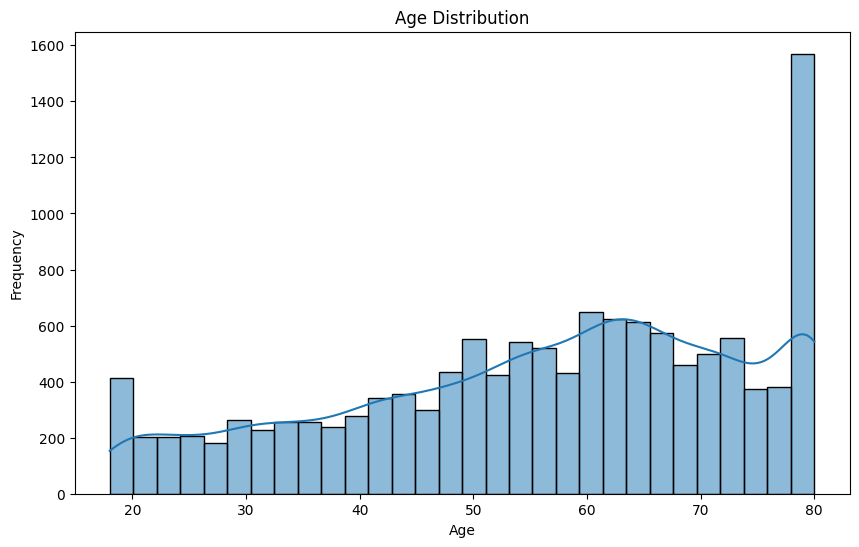

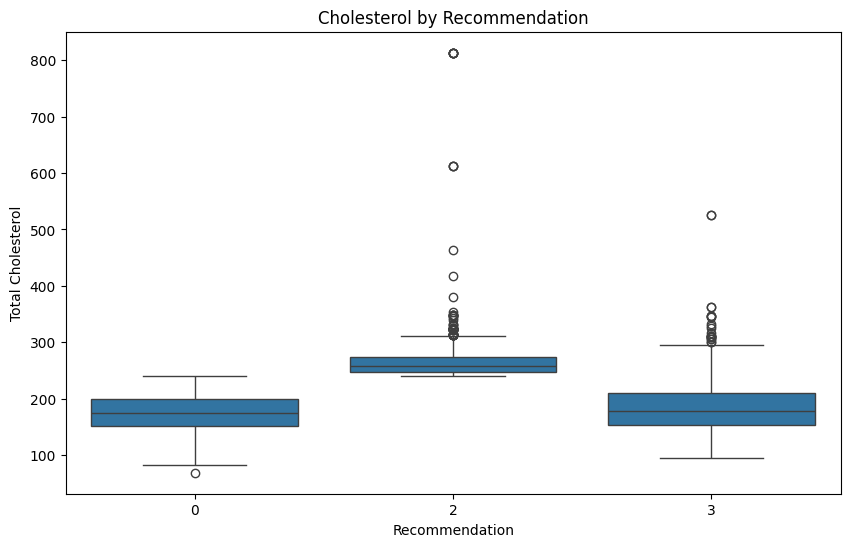

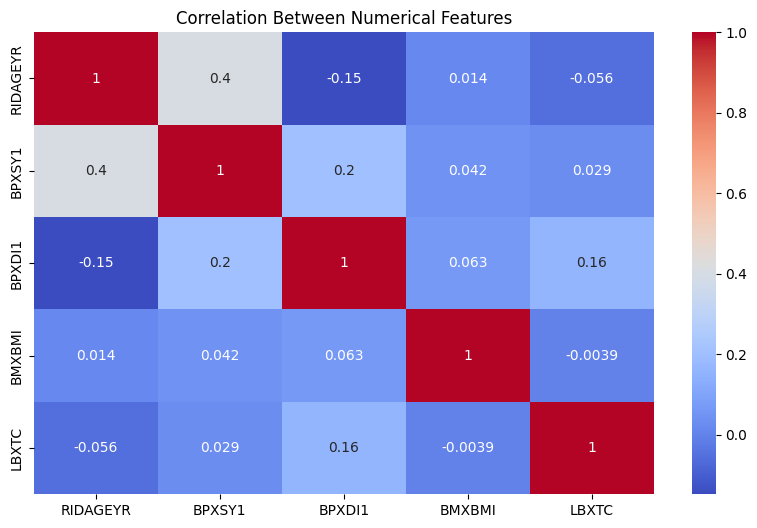

In [ ]:
# Step 7: Data Visualization

plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='recommendation', y='LBXTC', data=data)
plt.title('Cholesterol by Recommendation')
plt.xlabel('Recommendation')
plt.ylabel('Total Cholesterol')
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(data[num_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.show()

In [ ]:
# Step 8: Preprocessing

num_pipeline = Pipeline([('scaler', StandardScaler())])
cat_pipeline = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [ ]:
# Step 9: Train-Test Split

X = data[num_features + cat_features]
y = data['recommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 10: Model Training

model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['RIDAGEYR', 'BPXSY1',
                                                   'BPXDI1', 'BMXBMI',
                                                   'LBXTC']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['RIAGENDR', 'SMQ020',
                                                   'PAQ605'])])),
                ('clf', RandomForestClassifier(random_state=42))])

In [ ]:
# Step 11: Evaluation

y_pred = model.predict(X_test)
print("\nCONFUSION MATRIX")
print(confusion_matrix(y_test, y_pred))
print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))


CONFUSION MATRIX
[[1903    0    0]
 [   0  176    0]
 [   0    0  505]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1903
           2       1.00      1.00      1.00       176
           3       1.00      1.00      1.00       505

    accuracy                           1.00      2584
   macro avg       1.00      1.00      1.00      2584
weighted avg       1.00      1.00      1.00      2584



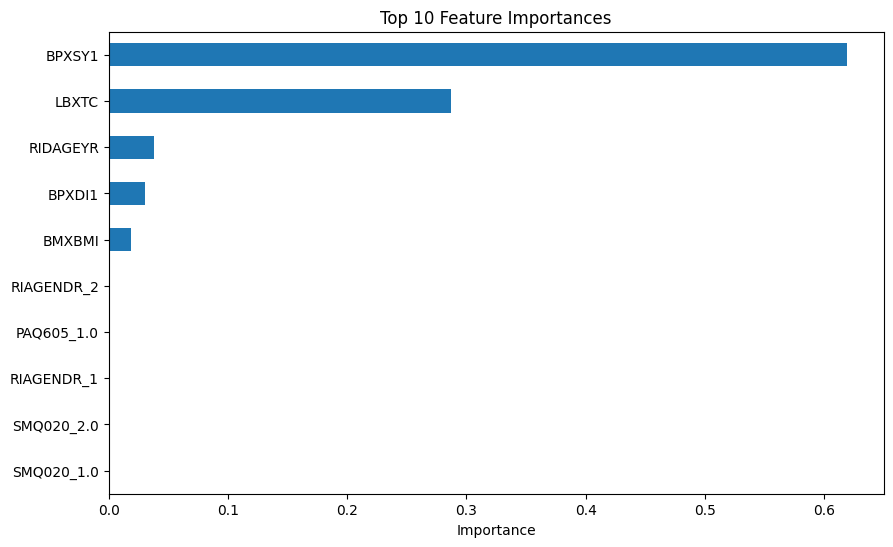

In [ ]:
# Step 12: Feature Importance Visualization

rf_model = model.named_steps['clf']
feature_names = model.named_steps['prep'].transformers_[0][2] + list(model.named_steps['prep'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features))
importances = rf_model.feature_importances_
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_importance.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

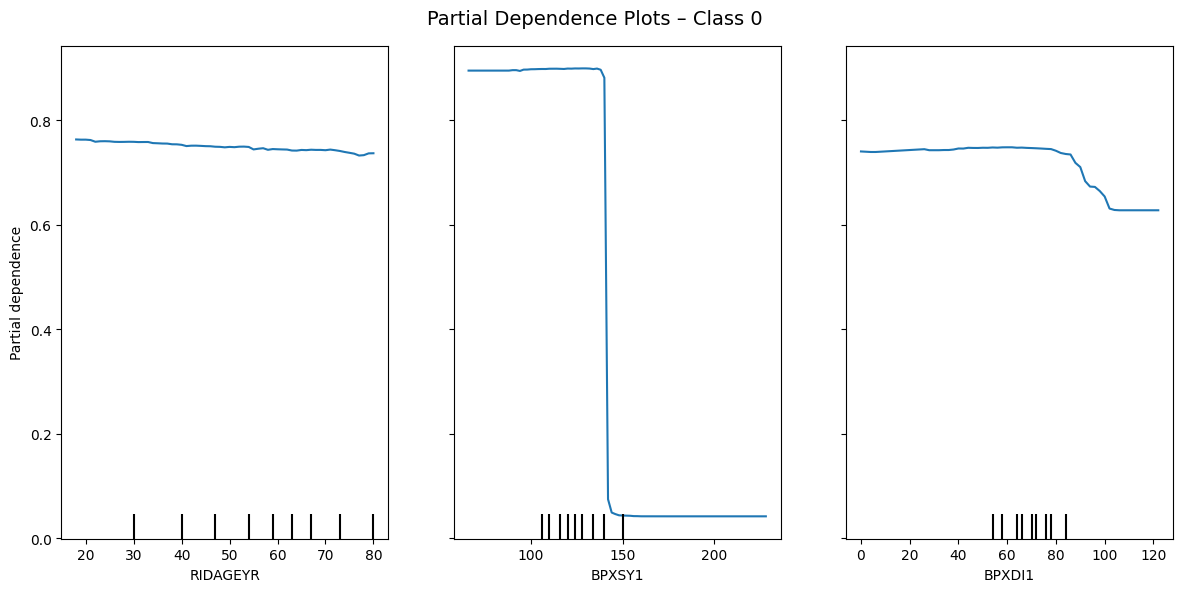

In [ ]:
# Step 13: Partial Dependence Plots (Corrected for Multi-class)

from sklearn.inspection import PartialDependenceDisplay

# Choose the target class (e.g., 0, 1, 2, or 3)
target_class = 0

# Generate partial dependence plots for selected features
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=num_features[:3],
    kind="average",
    target=target_class,
    ax=ax
)
plt.suptitle(f"Partial Dependence Plots – Class {target_class}", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Step 14: Recommendation Function

def generate_recommendation(patient_input):
    pred = model.predict(patient_input)
    suggestions = {
        0: "No immediate action needed",
        1: "Schedule regular checkups",
        2: "Recommend lifestyle changes",
        3: "Medical consultation advised"
    }
    return suggestions.get(pred[0], "No suggestion")

In [ ]:
# Step 15: Run Sample Recommendation

sample = pd.DataFrame({
    'RIDAGEYR': [60],
    'BPXSY1': [145],
    'BPXDI1': [88],
    'BMXBMI': [32],
    'LBXGLU': [120],
    'LBXTC': [260],
    'RIAGENDR': ['1'],
    'SMQ020': ['2'],
    'PAQ605': ['2']
})

print("\nSAMPLE PATIENT RECOMMENDATION:")
print(generate_recommendation(sample))


SAMPLE PATIENT RECOMMENDATION:
Medical consultation advised


In [ ]:
# Step 16: Content-Based Recommendation (System Implementation)

# Create a function that ranks recommendations for new patients based on similar health profiles
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_patients(new_patient, dataset, top_n=5):
    # Fit the preprocessing pipeline
    transformed_dataset = model.named_steps['prep'].transform(dataset[num_features + cat_features])
    transformed_patient = model.named_steps['prep'].transform(new_patient[num_features + cat_features])

    # Calculate cosine similarity
    similarities = cosine_similarity(transformed_patient, transformed_dataset)
    top_indices = similarities[0].argsort()[::-1][:top_n]

    # Return top matches from original dataset
    return dataset.iloc[top_indices][['SEQN'] + num_features + cat_features + ['recommendation']]

# Example usage
print("\nTop 5 Similar Patient Profiles:")
similar_patients = recommend_similar_patients(sample, data)
print(similar_patients)




Top 5 Similar Patient Profiles:
        SEQN  RIDAGEYR  BPXSY1  BPXDI1  BMXBMI  LBXTC  RIAGENDR  SMQ020  \
2369   74695        53   172.0    96.0    28.7  317.0         1     1.0   
18454  82822        56   162.0   100.0    32.8  277.0         1     1.0   
18456  82822        56   162.0   100.0    32.8  277.0         1     1.0   
18455  82822        56   162.0   100.0    32.8  277.0         1     1.0   
17033  82043        57   146.0    90.0    34.5  329.0         2     1.0   

       PAQ605  recommendation  
2369      2.0               3  
18454     2.0               3  
18456     2.0               3  
18455     2.0               3  
17033     2.0               3  


In [ ]:
# Step 16.2: Clustering-Based Recommendation (Alternate System)

from sklearn.cluster import KMeans

# Apply KMeans to grouped patient profiles
data_cluster = data[num_features + cat_features].copy()
data_cluster_encoded = preprocessor.fit_transform(data_cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(data_cluster_encoded)

# Assign cluster to new patient
sample_encoded = preprocessor.transform(sample[num_features + cat_features])
sample_cluster = kmeans.predict(sample_encoded)[0]

# Recommend based on patients in same cluster
cluster_group = data[data['cluster'] == sample_cluster]
print(f"\nCluster {sample_cluster} contains {len(cluster_group)} similar patients.")
print("Cluster-Based Average Recommendations:")
print(cluster_group['recommendation'].value_counts(normalize=True))




 ##### THIS IS A WORK DONE BY 'SURENDRAN L'


Cluster 0 contains 2860 similar patients.
Cluster-Based Average Recommendations:
recommendation
3    0.546154
0    0.341958
2    0.111888
Name: proportion, dtype: float64
